In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torch.optim import Adam
from peft import get_peft_model, LoraConfig, TaskType
from task2_signal import generate_signal
from task2_signal import generate_volatility_signal
from task2_stocks import get_stock_data
from task2_news import get_news


# Date ranges for the starter solution
END_DATE = "2023-10-16"
START_DATE = "2022-12-16"

"""a very simple env whost state space is only the data"""
STOCK_TICKERS_HIGHEST_CAP_US = [
    "AAPL"
]

"""load data and make dset - first we load in the ticker data for each ticker, then we enrich that with news data"""

stock_data = pd.read_csv("./competition_dsets/task2_stocks.csv")


stock_data['Date'] = pd.to_datetime(stock_data['Date'])


stock_data = stock_data[(stock_data['Ticker'].isin(STOCK_TICKERS_HIGHEST_CAP_US)) &
                        (stock_data['Date'] >= START_DATE) &
                        (stock_data['Date'] <= END_DATE)]

stock_data.head()

/nfs/home/klt0112/.conda/envs/financerag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-07 19:40:58.774795: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 19:40:58.792718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731008458.812425  761731 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731008458.818450  761731 cuda_bla

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
746,2022-12-16,136.690002,137.649994,133.729996,134.509995,133.256653,160156900,AAPL
747,2022-12-19,135.110001,135.199997,131.320007,132.369995,131.136597,79592600,AAPL
748,2022-12-20,131.389999,133.250000,129.889999,132.300003,131.067261,77432800,AAPL
749,2022-12-21,132.979996,136.809998,132.750000,135.449997,134.187897,85928000,AAPL
750,2022-12-22,134.350006,134.559998,130.300003,132.229996,130.997910,77852100,AAPL


In [2]:
# Load ESG data
esg_data = pd.read_csv("esg_data.csv")
esg_data['Date'] = pd.to_datetime(esg_data['Date'])

technical_data = pd.read_csv("AAPL_predictions_cleaned.csv")
technical_data['Date'] = pd.to_datetime(technical_data['Date'])

In [3]:
# Sort by date to ensure correct chronological order
esg_data = esg_data.sort_values('Date').reset_index(drop=True)
# Calculate the 1-month percentage difference
esg_data['ESG_pct_diff_1m'] = esg_data['ESG_score'].pct_change(periods=30) * 100  
esg_data['ESG_score'] = esg_data['ESG_pct_diff_1m']


In [4]:
from task2_env import Task2Env

bnb_config_4 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,  # or torch.bfloat16
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="fp4",  # 'nf4' or 'fp4'
)

bnb_config_8 = BitsAndBytesConfig(load_in_8bit=True)

num_gpus = torch.cuda.device_count()
max_memory = {i: "16GiB" for i in range(num_gpus)}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # map to auto for multi gpu
model_name = "meta-llama/Llama-3.2-3B-Instruct"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # quantization_config=bnb_config_4,
    device_map="auto",
    # max_memory=max_memory,
)
# model = torch.nn.DataParallel(model)
# model.to(device)

# grad checkpntg
model.gradient_checkpointing_enable()
model.enable_input_require_grads()
model.config.use_cache = False

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.62s/it]


In [6]:
# LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=30,
    target_modules=["q_proj", "v_proj"],
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Initialize environment
from task2_env import Task2Env

# Assuming model, tokenizer, stock_data, esg_data, and tech_analysis_data are already defined
task2env = Task2Env(
    model=model,
    tokenizer=tokenizer,
    stock_data=stock_data,
    esg_data=esg_data,
    tech_analysis_data=technical_data,  # New parameter for technical analysis
    scale_range=(-10, 10),
    max_steps=252 - 4,
    threshold=3,
    lookahead = 3, 
    strong_positive_return=0.05,  # Strong positive return threshold
    moderate_positive_return=0.02,  # Moderate positive return threshold
    weak_positive_return=0.005,  # Weak positive return threshold
    low_risk_threshold=4,  # Updated low-risk volatility threshold
    reward_hyperparams={
        'great_positive_reward': 2.0,
        'moderate_positive_reward': 1.5,
        'weak_positive_reward': 1.0,
        'passive_reward': 0.0,
        'moderate_negative_reward': -1.0,
        'strong_negative_reward': -1.5,
        'esg_bonus': 0.1,
    }
)

state = task2env.reset()
actions = []
rewards = []
returns = []
running_eval = []
losses = []

optimizer = Adam(model.parameters(), lr=1e-5)

trainable params: 8,601,600 || all params: 3,221,351,424 || trainable%: 0.2670


In [8]:
# Define parameters for tracking and adjusting rewards
max_train_steps = 180
previous_eval_values = []  # List to store recent portfolio evaluations
trend_days = 3  # Number of consecutive days to consider for trend analysis
increase_factor = 1.1  # Factor to increase rewards if portfolio trend is positive
decrease_factor = 1.1  # Factor to increase negative penalties if portfolio trend is negative

for step in tqdm(range(max_train_steps), desc=f"Training for max steps: {max_train_steps}"):
    date, prices = state
    date = pd.Timestamp(date)
    done = False

    news = get_news(
            "AAPL",
            (date - timedelta(days=1))._date_repr,
            (date - timedelta(days=11))._date_repr,
            "./competition_dsets/task2_news.csv",
        )

    # Generate sentiment score and log probability
    sentiment_score, log_prob_sentiment = generate_signal(
        tokenizer,
        model,
        device,
        news,
    )

    # Prepare recent prices for volatility analysis
    recent_prices = stock_data[
        (stock_data['Date'] <= date.strftime('%Y-%m-%d')) &
        (stock_data['Date'] > (date - timedelta(days=5)).strftime('%Y-%m-%d'))
    ]['Close'].tolist()

    # Generate volatility score and log probability
    volatility_score, log_prob_volatility = generate_volatility_signal(
        tokenizer,
        model,
        device,
        news,
        recent_prices,
    )

    action = {
        'sentiment': sentiment_score,
        'volatility': volatility_score,
    }

    state, reward, done, info = task2env.step(action)
    actions.append(action)
    rewards.append(reward)
    returns.append(info["price change"])
    running_eval.append(info["running eval"])

    # Append current eval value and keep only the last 'trend_days' values
    previous_eval_values.append(info["running eval"])
    if len(previous_eval_values) > trend_days:
        previous_eval_values.pop(0)

    # Check if portfolio has increased or decreased consistently over 'trend_days'
    if len(previous_eval_values) == trend_days:
        # Check if all values in the trend are increasing
        if all(previous_eval_values[i] < previous_eval_values[i + 1] for i in range(trend_days - 1)):
            # Increase positive rewards if portfolio has been increasing for 'trend_days' consecutively
            task2env.reward_hyperparams['great_positive_reward'] *= increase_factor
            task2env.reward_hyperparams['moderate_positive_reward'] *= increase_factor
            task2env.reward_hyperparams['weak_positive_reward'] *= increase_factor
        elif all(previous_eval_values[i] > previous_eval_values[i + 1] for i in range(trend_days - 1)):
            # Increase negative penalties if portfolio has been decreasing for 'trend_days' consecutively
            task2env.reward_hyperparams['moderate_negative_reward'] *= decrease_factor
            task2env.reward_hyperparams['strong_negative_reward'] *= decrease_factor

        # Set hyperparameters for the advanced loss function
    alpha_sentiment = 0.7  # Weight for sentiment log probability
    alpha_volatility = 0.3  # Weight for volatility log probability
    risk_aversion = 0.5     # Penalizes risk to prevent extreme losses
    smoothing_factor = 0.1  # Penalizes sudden portfolio changes

    # Advanced loss calculation
    reward_tensor = torch.tensor(reward, device=device)

    # Weighted log probabilities for sentiment and volatility
    log_prob_combined = alpha_sentiment * log_prob_sentiment + alpha_volatility * log_prob_volatility

    # Risk-adjusted reward (e.g., Sharpe-inspired): reward - (risk_aversion * volatility_score)
    risk_adjusted_reward = reward_tensor - risk_aversion * torch.tensor(volatility_score, device=device)

    # Temporal consistency: penalize large changes in portfolio value (using `returns`)
    if len(returns) > 1:
        recent_return_change = returns[-1] - returns[-2]
        temporal_penalty = smoothing_factor * torch.abs(torch.tensor(recent_return_change, device=device))
    else:
        temporal_penalty = torch.tensor(0.0, device=device)

    # Define the advanced loss as the weighted negative log probability adjusted by risk and consistency
    loss = -(log_prob_combined * risk_adjusted_reward) + temporal_penalty
    loss = loss.mean()

    # Standard backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if done:
        break

Training for max steps: 180:   0%|          | 0/180 [00:00<?, ?it/s]

0.0


Training for max steps: 180:   1%|          | 1/180 [00:06<18:59,  6.36s/it]

9.0


Training for max steps: 180:   1%|          | 2/180 [00:12<17:54,  6.04s/it]

10.0


Training for max steps: 180:   2%|▏         | 3/180 [00:18<17:40,  5.99s/it]

0


Training for max steps: 180:   2%|▏         | 4/180 [00:23<17:25,  5.94s/it]

15.0


Training for max steps: 180:   3%|▎         | 5/180 [00:29<17:06,  5.86s/it]

0


Training for max steps: 180:   3%|▎         | 6/180 [00:35<17:00,  5.86s/it]

8.0


Training for max steps: 180:   4%|▍         | 7/180 [00:41<16:45,  5.81s/it]

9.0


Training for max steps: 180:   4%|▍         | 8/180 [00:47<16:35,  5.79s/it]

-10.0


Training for max steps: 180:   5%|▌         | 9/180 [00:52<16:26,  5.77s/it]

0.0


Training for max steps: 180:   6%|▌         | 10/180 [00:58<16:18,  5.76s/it]

0.0


Training for max steps: 180:   6%|▌         | 11/180 [01:04<16:13,  5.76s/it]

0


Training for max steps: 180:   7%|▋         | 12/180 [01:09<16:05,  5.75s/it]

9.0


Training for max steps: 180:   7%|▋         | 13/180 [01:15<15:55,  5.72s/it]

0.0


Training for max steps: 180:   8%|▊         | 14/180 [01:21<15:50,  5.72s/it]

-10.0


Training for max steps: 180:   8%|▊         | 15/180 [01:27<15:46,  5.74s/it]

1.0


Training for max steps: 180:   9%|▉         | 16/180 [01:32<15:36,  5.71s/it]

8.0


Training for max steps: 180:   9%|▉         | 17/180 [01:38<15:30,  5.71s/it]

0


Training for max steps: 180:  10%|█         | 18/180 [01:44<15:38,  5.79s/it]

-3.0


Training for max steps: 180:  11%|█         | 19/180 [01:50<15:39,  5.84s/it]

10.0


Training for max steps: 180:  11%|█         | 20/180 [01:56<15:36,  5.86s/it]

0


Training for max steps: 180:  12%|█▏        | 21/180 [02:01<15:23,  5.81s/it]

0


Training for max steps: 180:  12%|█▏        | 22/180 [02:07<15:14,  5.79s/it]

5.0


Training for max steps: 180:  13%|█▎        | 23/180 [02:13<15:09,  5.79s/it]

5.0


Training for max steps: 180:  13%|█▎        | 24/180 [02:19<15:01,  5.78s/it]

0.0


Training for max steps: 180:  14%|█▍        | 25/180 [02:24<14:52,  5.76s/it]

-3.0


Training for max steps: 180:  14%|█▍        | 26/180 [02:30<14:45,  5.75s/it]

9.0


Training for max steps: 180:  15%|█▌        | 27/180 [02:36<14:39,  5.75s/it]

10.0


Training for max steps: 180:  16%|█▌        | 28/180 [02:42<14:38,  5.78s/it]

8.0


Training for max steps: 180:  16%|█▌        | 29/180 [02:48<14:31,  5.77s/it]

9.0


Training for max steps: 180:  17%|█▋        | 30/180 [02:53<14:23,  5.76s/it]

0.0


Training for max steps: 180:  17%|█▋        | 31/180 [02:59<14:16,  5.75s/it]

8.0


Training for max steps: 180:  18%|█▊        | 32/180 [03:05<14:10,  5.75s/it]

0


Training for max steps: 180:  18%|█▊        | 33/180 [03:11<14:17,  5.84s/it]

2.0


Training for max steps: 180:  19%|█▉        | 34/180 [03:17<14:09,  5.82s/it]

13.0


Training for max steps: 180:  19%|█▉        | 35/180 [03:22<14:03,  5.82s/it]

7.0


Training for max steps: 180:  20%|██        | 36/180 [03:28<13:53,  5.79s/it]

8.0


Training for max steps: 180:  21%|██        | 37/180 [03:34<13:49,  5.80s/it]

0


Training for max steps: 180:  21%|██        | 38/180 [03:40<13:41,  5.79s/it]

0


Training for max steps: 180:  22%|██▏       | 39/180 [03:46<13:39,  5.81s/it]

6.0


Training for max steps: 180:  22%|██▏       | 40/180 [03:51<13:30,  5.79s/it]

8.0


Training for max steps: 180:  23%|██▎       | 41/180 [03:57<13:21,  5.77s/it]

10.0


Training for max steps: 180:  23%|██▎       | 42/180 [04:03<13:16,  5.77s/it]

10.0


Training for max steps: 180:  24%|██▍       | 43/180 [04:09<13:11,  5.78s/it]

9.0


Training for max steps: 180:  24%|██▍       | 44/180 [04:14<13:03,  5.76s/it]

9.0


Training for max steps: 180:  25%|██▌       | 45/180 [04:20<12:56,  5.75s/it]

6.0


Training for max steps: 180:  26%|██▌       | 46/180 [04:26<12:48,  5.74s/it]

0


Training for max steps: 180:  26%|██▌       | 47/180 [04:31<12:41,  5.73s/it]

0


Training for max steps: 180:  27%|██▋       | 48/180 [04:37<12:35,  5.73s/it]

10.0


Training for max steps: 180:  27%|██▋       | 49/180 [04:43<12:31,  5.74s/it]

8.0


Training for max steps: 180:  28%|██▊       | 50/180 [04:49<12:26,  5.74s/it]

7.0


Training for max steps: 180:  28%|██▊       | 51/180 [04:54<12:20,  5.74s/it]

0.0


Training for max steps: 180:  29%|██▉       | 52/180 [05:00<12:16,  5.76s/it]

-10.0


Training for max steps: 180:  29%|██▉       | 53/180 [05:06<12:11,  5.76s/it]

8.0


Training for max steps: 180:  30%|███       | 54/180 [05:12<12:03,  5.74s/it]

0


Training for max steps: 180:  31%|███       | 55/180 [05:17<11:58,  5.75s/it]

0


Training for max steps: 180:  31%|███       | 56/180 [05:23<11:53,  5.76s/it]

0.0


Training for max steps: 180:  32%|███▏      | 57/180 [05:29<11:48,  5.76s/it]

0


Training for max steps: 180:  32%|███▏      | 58/180 [05:35<11:43,  5.76s/it]

9.0


Training for max steps: 180:  33%|███▎      | 59/180 [05:41<11:36,  5.75s/it]

9.9


Training for max steps: 180:  33%|███▎      | 60/180 [05:46<11:32,  5.77s/it]

0


Training for max steps: 180:  34%|███▍      | 61/180 [05:52<11:28,  5.79s/it]

8.0


Training for max steps: 180:  34%|███▍      | 62/180 [05:58<11:21,  5.77s/it]

8.0


Training for max steps: 180:  35%|███▌      | 63/180 [06:04<11:14,  5.77s/it]

-8.0


Training for max steps: 180:  36%|███▌      | 64/180 [06:09<11:06,  5.75s/it]

4.0


Training for max steps: 180:  36%|███▌      | 65/180 [06:15<11:00,  5.75s/it]

0


Training for max steps: 180:  37%|███▋      | 66/180 [06:21<10:52,  5.73s/it]

14.0


Training for max steps: 180:  37%|███▋      | 67/180 [06:27<10:49,  5.75s/it]

9.0


Training for max steps: 180:  38%|███▊      | 68/180 [06:32<10:42,  5.74s/it]

12.0


Training for max steps: 180:  38%|███▊      | 69/180 [06:38<10:34,  5.72s/it]

0


Training for max steps: 180:  39%|███▉      | 70/180 [06:44<10:30,  5.73s/it]

10.0


Training for max steps: 180:  39%|███▉      | 71/180 [06:50<10:26,  5.75s/it]

10.0


Training for max steps: 180:  40%|████      | 72/180 [06:55<10:21,  5.75s/it]

9.0


Training for max steps: 180:  41%|████      | 73/180 [07:01<10:15,  5.75s/it]

5.0


Training for max steps: 180:  41%|████      | 74/180 [07:07<10:08,  5.74s/it]

8.0


Training for max steps: 180:  42%|████▏     | 75/180 [07:12<10:02,  5.73s/it]

0


Training for max steps: 180:  42%|████▏     | 76/180 [07:18<09:55,  5.72s/it]

8.0


Training for max steps: 180:  43%|████▎     | 77/180 [07:24<09:49,  5.72s/it]

0


Training for max steps: 180:  43%|████▎     | 78/180 [07:30<09:43,  5.72s/it]

3.0


Training for max steps: 180:  44%|████▍     | 79/180 [07:35<09:37,  5.72s/it]

4.0


Training for max steps: 180:  44%|████▍     | 80/180 [07:41<09:31,  5.71s/it]

0


Training for max steps: 180:  45%|████▌     | 81/180 [07:47<09:24,  5.71s/it]

8.0


Training for max steps: 180:  46%|████▌     | 82/180 [07:52<09:18,  5.70s/it]

9.0


Training for max steps: 180:  46%|████▌     | 83/180 [07:58<09:13,  5.71s/it]

0


Training for max steps: 180:  47%|████▋     | 84/180 [08:04<09:06,  5.70s/it]

12.0


Training for max steps: 180:  47%|████▋     | 85/180 [08:09<08:58,  5.67s/it]

8.0


Training for max steps: 180:  48%|████▊     | 86/180 [08:15<08:52,  5.66s/it]

9.0


Training for max steps: 180:  48%|████▊     | 87/180 [08:21<08:47,  5.68s/it]

9.0


Training for max steps: 180:  49%|████▉     | 88/180 [08:26<08:43,  5.69s/it]

9.0


Training for max steps: 180:  49%|████▉     | 89/180 [08:32<08:37,  5.68s/it]

9.0


Training for max steps: 180:  50%|█████     | 90/180 [08:38<08:30,  5.67s/it]

9.0


Training for max steps: 180:  51%|█████     | 91/180 [08:44<08:26,  5.69s/it]

10.0


Training for max steps: 180:  51%|█████     | 92/180 [08:49<08:20,  5.69s/it]

9.0


Training for max steps: 180:  52%|█████▏    | 93/180 [08:55<08:14,  5.68s/it]

5.0


Training for max steps: 180:  52%|█████▏    | 94/180 [09:00<08:07,  5.67s/it]

19.0


Training for max steps: 180:  53%|█████▎    | 95/180 [09:06<08:00,  5.65s/it]

10.0


Training for max steps: 180:  53%|█████▎    | 96/180 [09:12<07:54,  5.65s/it]

9.0


Training for max steps: 180:  54%|█████▍    | 97/180 [09:17<07:49,  5.66s/it]

8.0


Training for max steps: 180:  54%|█████▍    | 98/180 [09:23<07:43,  5.66s/it]

8.0


Training for max steps: 180:  55%|█████▌    | 99/180 [09:29<07:36,  5.64s/it]

9.0


Training for max steps: 180:  56%|█████▌    | 100/180 [09:34<07:31,  5.64s/it]

23.0


Training for max steps: 180:  56%|█████▌    | 101/180 [09:40<07:26,  5.65s/it]

-10.0


Training for max steps: 180:  57%|█████▋    | 102/180 [09:46<07:20,  5.64s/it]

0


Training for max steps: 180:  57%|█████▋    | 103/180 [09:51<07:14,  5.64s/it]

5.0


Training for max steps: 180:  58%|█████▊    | 104/180 [09:57<07:08,  5.64s/it]

4.0


Training for max steps: 180:  58%|█████▊    | 105/180 [10:03<07:03,  5.64s/it]

8.0


Training for max steps: 180:  59%|█████▉    | 106/180 [10:08<06:57,  5.64s/it]

10.0


Training for max steps: 180:  59%|█████▉    | 107/180 [10:14<06:51,  5.64s/it]

5.0


Training for max steps: 180:  60%|██████    | 108/180 [10:19<06:45,  5.63s/it]

8.8


Training for max steps: 180:  61%|██████    | 109/180 [10:25<06:39,  5.63s/it]

9.0


Training for max steps: 180:  61%|██████    | 110/180 [10:31<06:36,  5.67s/it]

10.0


Training for max steps: 180:  62%|██████▏   | 111/180 [10:37<06:31,  5.67s/it]

0


Training for max steps: 180:  62%|██████▏   | 112/180 [10:42<06:25,  5.68s/it]

15.0


Training for max steps: 180:  63%|██████▎   | 113/180 [10:48<06:18,  5.65s/it]

8.0


Training for max steps: 180:  63%|██████▎   | 114/180 [10:53<06:13,  5.65s/it]

8.0


Training for max steps: 180:  64%|██████▍   | 115/180 [10:59<06:06,  5.64s/it]

23.0


Training for max steps: 180:  64%|██████▍   | 116/180 [11:05<06:01,  5.64s/it]

9.0


Training for max steps: 180:  65%|██████▌   | 117/180 [11:10<05:55,  5.64s/it]

1.0


Training for max steps: 180:  66%|██████▌   | 118/180 [11:16<05:50,  5.66s/it]

0


Training for max steps: 180:  66%|██████▌   | 119/180 [11:22<05:46,  5.68s/it]

9.2


Training for max steps: 180:  67%|██████▋   | 120/180 [11:27<05:40,  5.67s/it]

0


Training for max steps: 180:  67%|██████▋   | 121/180 [11:33<05:34,  5.66s/it]

0


Training for max steps: 180:  68%|██████▊   | 122/180 [11:39<05:28,  5.66s/it]

0


Training for max steps: 180:  68%|██████▊   | 123/180 [11:44<05:23,  5.67s/it]

6.0


Training for max steps: 180:  69%|██████▉   | 124/180 [11:50<05:17,  5.66s/it]

8.0


Training for max steps: 180:  69%|██████▉   | 125/180 [11:56<05:11,  5.66s/it]

5.0


Training for max steps: 180:  70%|███████   | 126/180 [12:01<05:05,  5.67s/it]

8.0


Training for max steps: 180:  71%|███████   | 127/180 [12:07<05:00,  5.67s/it]

6.0


Training for max steps: 180:  71%|███████   | 128/180 [12:13<04:55,  5.68s/it]

0


Training for max steps: 180:  72%|███████▏  | 129/180 [12:18<04:49,  5.69s/it]

1.0


Training for max steps: 180:  72%|███████▏  | 130/180 [12:24<04:44,  5.69s/it]

0


Training for max steps: 180:  73%|███████▎  | 131/180 [12:30<04:38,  5.69s/it]

6.0


Training for max steps: 180:  73%|███████▎  | 132/180 [12:36<04:37,  5.78s/it]

10.0


Training for max steps: 180:  74%|███████▍  | 133/180 [12:41<04:29,  5.74s/it]

0


Training for max steps: 180:  74%|███████▍  | 134/180 [12:47<04:22,  5.71s/it]

0


Training for max steps: 180:  75%|███████▌  | 135/180 [12:53<04:16,  5.70s/it]

7.0


Training for max steps: 180:  76%|███████▌  | 136/180 [12:59<04:11,  5.71s/it]

9.0


Training for max steps: 180:  76%|███████▌  | 137/180 [13:04<04:06,  5.73s/it]

3.0


Training for max steps: 180:  77%|███████▋  | 138/180 [13:10<03:59,  5.71s/it]

9.0


Training for max steps: 180:  77%|███████▋  | 139/180 [13:16<03:53,  5.69s/it]

0


Training for max steps: 180:  78%|███████▊  | 140/180 [13:21<03:47,  5.69s/it]

9.0


Training for max steps: 180:  78%|███████▊  | 141/180 [13:27<03:41,  5.69s/it]

0


Training for max steps: 180:  79%|███████▉  | 142/180 [13:33<03:36,  5.69s/it]

9.0


Training for max steps: 180:  79%|███████▉  | 143/180 [13:38<03:30,  5.69s/it]

9.0


Training for max steps: 180:  80%|████████  | 144/180 [13:44<03:25,  5.70s/it]

0.0


Training for max steps: 180:  81%|████████  | 145/180 [13:50<03:19,  5.71s/it]

8.0


Training for max steps: 180:  81%|████████  | 146/180 [13:56<03:14,  5.73s/it]

10.0


Training for max steps: 180:  82%|████████▏ | 147/180 [14:01<03:09,  5.74s/it]

8.0


Training for max steps: 180:  82%|████████▏ | 148/180 [14:07<03:04,  5.76s/it]

9.0


Training for max steps: 180:  83%|████████▎ | 149/180 [14:13<02:57,  5.74s/it]

8.0


Training for max steps: 180:  83%|████████▎ | 150/180 [14:19<02:51,  5.73s/it]

0


Training for max steps: 180:  84%|████████▍ | 151/180 [14:24<02:46,  5.73s/it]

0.0


Training for max steps: 180:  84%|████████▍ | 152/180 [14:30<02:39,  5.70s/it]

-10.0


Training for max steps: 180:  85%|████████▌ | 153/180 [14:36<02:33,  5.69s/it]

0


Training for max steps: 180:  86%|████████▌ | 154/180 [14:42<02:29,  5.75s/it]

2.0


Training for max steps: 180:  86%|████████▌ | 155/180 [14:47<02:22,  5.72s/it]

0.0


Training for max steps: 180:  87%|████████▋ | 156/180 [14:53<02:16,  5.69s/it]

10.0


Training for max steps: 180:  87%|████████▋ | 157/180 [14:58<02:11,  5.70s/it]

0


Training for max steps: 180:  88%|████████▊ | 158/180 [15:04<02:05,  5.71s/it]

10.0


Training for max steps: 180:  88%|████████▊ | 159/180 [15:10<02:00,  5.75s/it]

8.0


Training for max steps: 180:  89%|████████▉ | 160/180 [15:16<01:55,  5.78s/it]

0


Training for max steps: 180:  89%|████████▉ | 161/180 [15:22<01:50,  5.80s/it]

3.0


Training for max steps: 180:  90%|█████████ | 162/180 [15:28<01:44,  5.82s/it]

8.0


Training for max steps: 180:  91%|█████████ | 163/180 [15:34<01:39,  5.84s/it]

5.0


Training for max steps: 180:  91%|█████████ | 164/180 [15:39<01:33,  5.86s/it]

10.0


Training for max steps: 180:  92%|█████████▏| 165/180 [15:45<01:27,  5.85s/it]

0


Training for max steps: 180:  92%|█████████▏| 166/180 [15:51<01:22,  5.89s/it]

0


Training for max steps: 180:  93%|█████████▎| 167/180 [15:57<01:16,  5.89s/it]

-3.0


Training for max steps: 180:  93%|█████████▎| 168/180 [16:03<01:09,  5.83s/it]

0


Training for max steps: 180:  94%|█████████▍| 169/180 [16:08<01:03,  5.78s/it]

0


Training for max steps: 180:  94%|█████████▍| 170/180 [16:14<00:57,  5.78s/it]

0


Training for max steps: 180:  95%|█████████▌| 171/180 [16:20<00:51,  5.73s/it]

9.0


Training for max steps: 180:  96%|█████████▌| 172/180 [16:25<00:45,  5.69s/it]

-10.0


Training for max steps: 180:  96%|█████████▌| 173/180 [16:31<00:40,  5.73s/it]

9.0


Training for max steps: 180:  97%|█████████▋| 174/180 [16:37<00:34,  5.76s/it]

0


Training for max steps: 180:  97%|█████████▋| 175/180 [16:43<00:28,  5.77s/it]

9.0


Training for max steps: 180:  98%|█████████▊| 176/180 [16:49<00:23,  5.80s/it]

-10.0


Training for max steps: 180:  98%|█████████▊| 177/180 [16:55<00:17,  5.82s/it]

19.0


Training for max steps: 180:  99%|█████████▉| 178/180 [17:00<00:11,  5.82s/it]

10.0


Training for max steps: 180:  99%|█████████▉| 179/180 [17:06<00:05,  5.85s/it]

0


Training for max steps: 180: 100%|██████████| 180/180 [17:12<00:00,  5.74s/it]


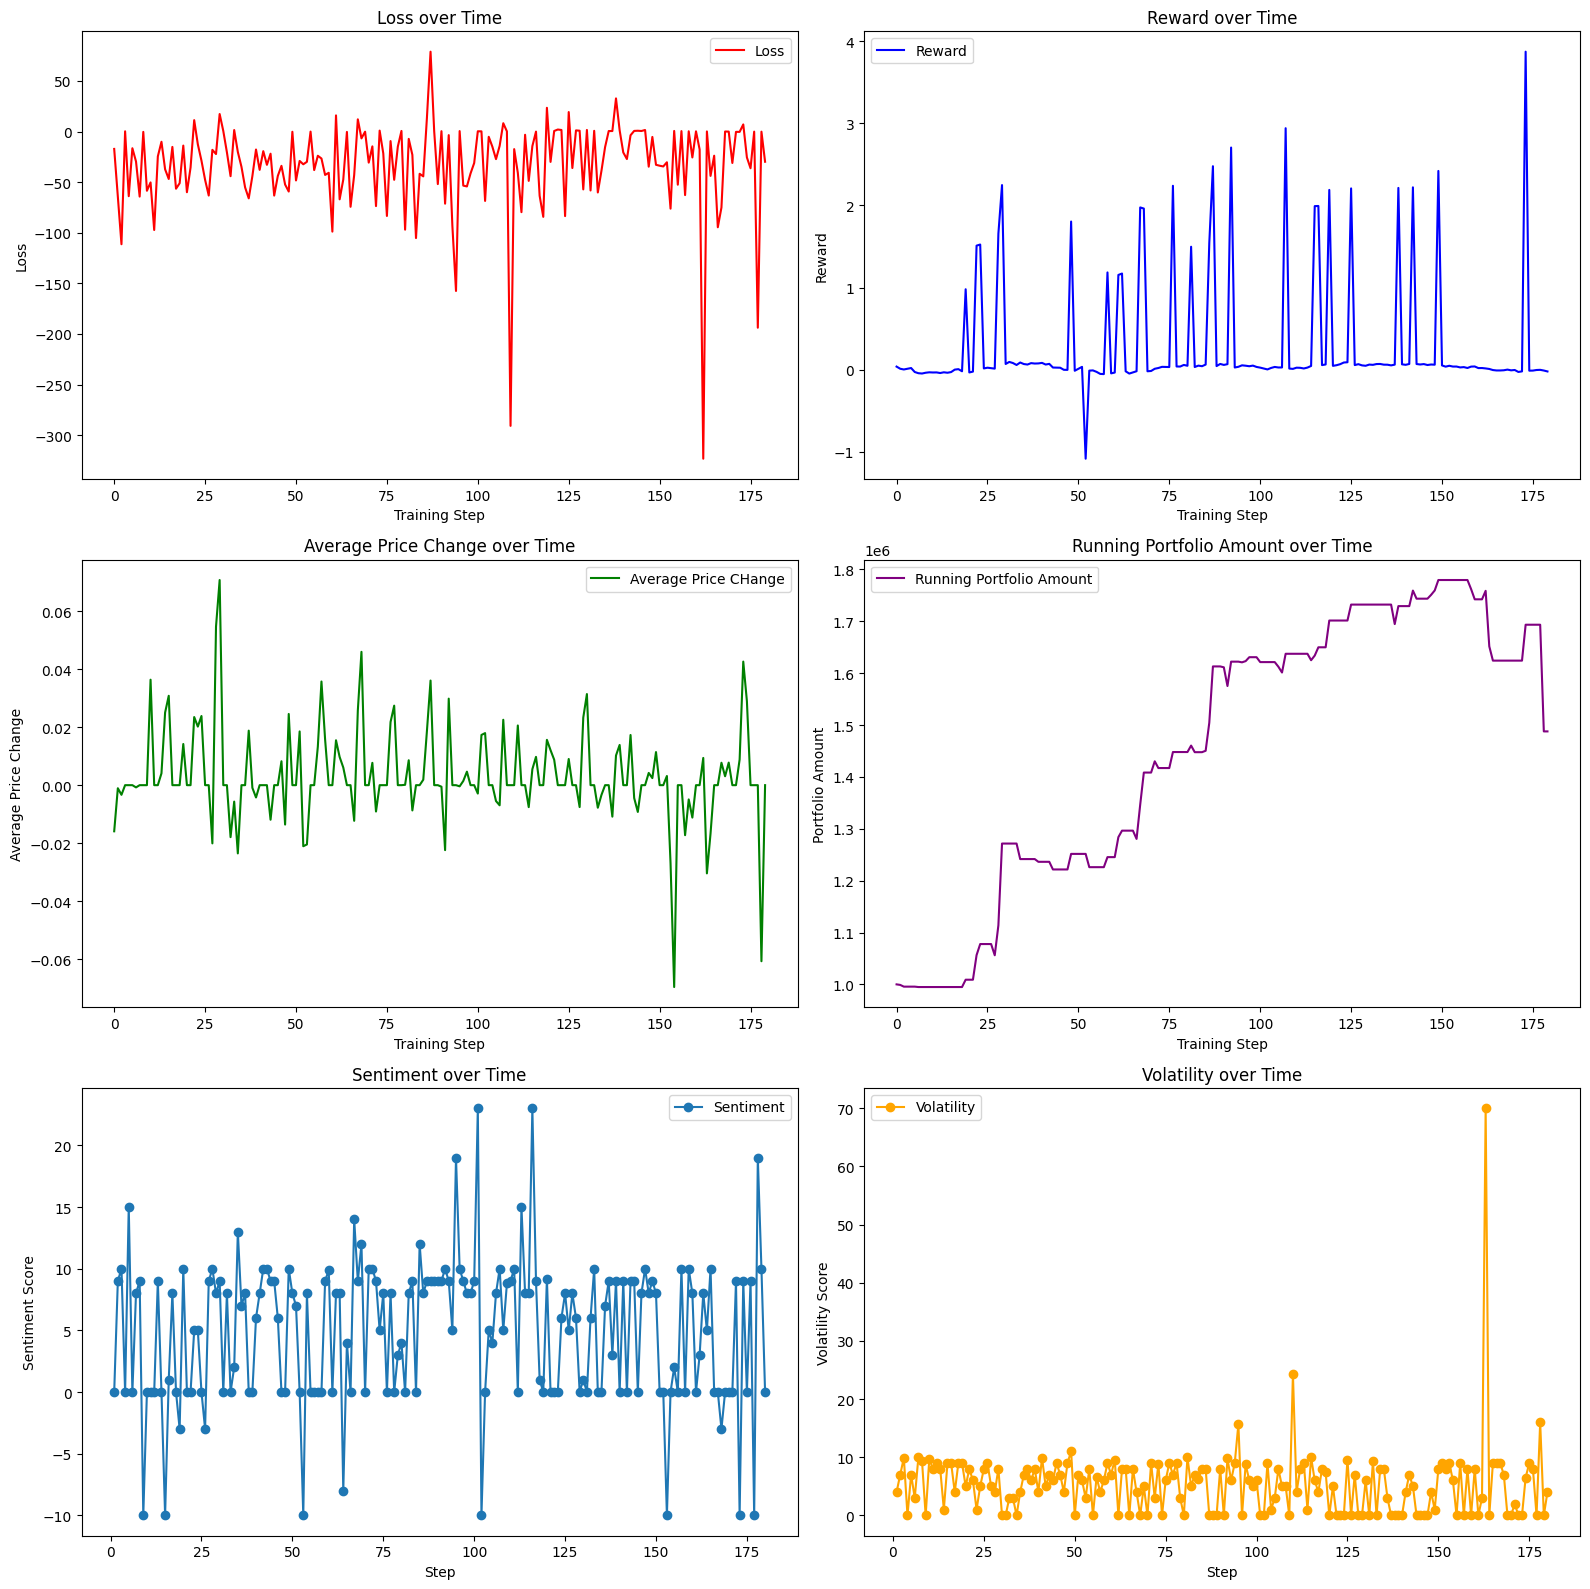

In [9]:
# Plotting results
plt.figure(figsize=(16, 16))

# Plot Loss over Time
plt.subplot(3, 2, 1)
plt.plot(losses, label="Loss", color="red")
plt.title("Loss over Time")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend()

# Plot Reward over Time
plt.subplot(3, 2, 2)
plt.plot(rewards, label="Reward", color="blue")
plt.title("Reward over Time")
plt.xlabel("Training Step")
plt.ylabel("Reward")
plt.legend()

# Plot Average Price Change over Time
plt.subplot(3, 2, 3)
plt.plot(returns, label="Average Price CHange", color="green")
plt.title("Average Price Change over Time")
plt.xlabel("Training Step")
plt.ylabel("Average Price Change")
plt.legend()

# Plot Running Evaluation Amount over Time
plt.subplot(3, 2, 4)
plt.plot(running_eval, label="Running Portfolio Amount", color="purple")
plt.title("Running Portfolio Amount over Time")
plt.xlabel("Training Step")
plt.ylabel("Portfolio Amount")
plt.legend()


# Extract sentiment and volatility values from the actions
sentiments = [action['sentiment'] for action in actions]
volatilities = [action['volatility'] for action in actions]
steps = list(range(1, len(actions) + 1))

# Plot Sentiment
plt.subplot(3, 2, 5)
plt.plot(steps, sentiments, marker='o', linestyle='-', label='Sentiment')
plt.xlabel('Step')
plt.ylabel('Sentiment Score')
plt.title('Sentiment over Time')
plt.legend()

# Plot Volatility
plt.subplot(3, 2, 6)
plt.plot(steps, volatilities, marker='o', linestyle='-', color='orange', label='Volatility')
plt.xlabel('Step')
plt.ylabel('Volatility Score')
plt.title('Volatility over Time')
plt.legend()

plt.tight_layout()
plt.savefig("training.png")